[UCR Time Series Anomaly Detection Benchmark Datasets](https://arxiv.org/pdf/2009.13807v5.pdf)

In [ ]:
! pip install git+https://github.com/alstonlo/torch-influence.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ! git clone https://github.com/ykwon0407/dataoob.git
%cd /content/drive/MyDrive/time_series_influences/dataoob
! pip install -e.

/content/drive/MyDrive/time_series_influences/dataoob
Obtaining file:///content/drive/MyDrive/time_series_influences/dataoob
  Preparing metadata (setup.py) ... done
  Running setup.py develop for dataoob


In [103]:
import time
import copy
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from scipy.signal import detrend
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

from dataoob.data_valuation import DataValuation

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
from torch_influence import BaseObjective, CGInfluenceModule

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [6]:
# -- utils
def create_dataset(dataset, lookback, device=None):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)

    if device is not None:
        return torch.tensor(X).to(device), torch.tensor(y).to(device)
    else:
        return np.array(X), np.array(y)


def create_auto_encoder_dataset(ts):

  sequences = ts.tolist()

  dataset = [torch.tensor(s).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [74]:
# -- torch influence functions
class Forecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=8, num_layers=1, batch_first=True)
        self.linear = nn.Linear(8, 1)
        self.flatten = nn.Flatten(start_dim=-2)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        x = self.flatten(x)
        return x

class TimeSeriesObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.mse_loss(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.mse_loss(outputs, batch[1])

In [8]:
# -- LSTM-AE
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(DEVICE)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(DEVICE)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x


def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
  criterion = nn.L1Loss(reduction='sum').to(DEVICE)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(DEVICE)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(DEVICE)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(DEVICE)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(DEVICE)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

My Naive Simulation

In [29]:
# -- load toy example data
series = sm.datasets.co2.load_pandas().data.dropna().to_numpy()[:800]

# -- corrupt data
duration = len(series)
contam_perc = 0.005
contam_duration = int(duration*.8)
anomaly_idx = np.random.choice(
    np.arange(contam_duration), int(contam_duration * contam_perc), replace=False
)
anomaly_scale = np.random.binomial(n=1, p=0.5, size=int(contam_duration * contam_perc))
anomaly_scale = [5 if scale > 0 else -5 for scale in anomaly_scale]
anomalies = series[anomaly_idx] + np.random.normal(anomaly_scale, 2.5).reshape(-1,1)
contam_series = series.copy()
contam_series[anomaly_idx] = anomalies

In [38]:
train_size = int(duration * 0.9)
test_size = duration - train_size
train, test = contam_series[:train_size], contam_series[train_size:]

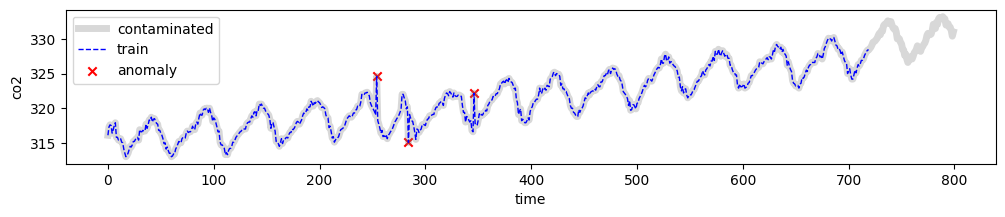

In [48]:
plt.figure(figsize=(12,2))
plt.plot(contam_series, color="gray", linestyle="-", linewidth=5, alpha=.3, label="contaminated")
plt.plot(train, color="b", linestyle="--", linewidth=1, label="train")
plt.scatter(anomaly_idx, anomalies, color='red', label='anomaly', marker="x")
plt.xlabel("time")
plt.ylabel("co2")
plt.legend()
plt.show()

In [49]:
lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback, device=DEVICE)
X_test, y_test = create_dataset(test, lookback=lookback, device=DEVICE)
y_train, y_test = y_train.squeeze(), y_test.squeeze()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([715, 5, 1]) torch.Size([715, 5])
torch.Size([75, 5, 1]) torch.Size([75, 5])


In [75]:
L2_WEIGHT = 1e-4
model = Forecaster().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=L2_WEIGHT)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [76]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().numpy())
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().numpy())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 320.4234, test RMSE 329.6600
Epoch 100: train RMSE 244.3581, test RMSE 253.5844
Epoch 200: train RMSE 170.8399, test RMSE 180.0310
Epoch 300: train RMSE 99.9117, test RMSE 108.9389
Epoch 400: train RMSE 39.7733, test RMSE 47.1258
Epoch 500: train RMSE 18.0098, test RMSE 22.2959
Epoch 600: train RMSE 2.8023, test RMSE 5.6824
Epoch 700: train RMSE 2.5009, test RMSE 5.7429
Epoch 800: train RMSE 2.6106, test RMSE 4.5788
Epoch 900: train RMSE 2.1563, test RMSE 4.9072


In [77]:
with torch.no_grad():
    contam_train_plot = np.ones_like(contam_series).squeeze() * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    contam_train_plot[lookback:train_size] = model(X_train)[:, -1].cpu().numpy()
    contam_test_plot = np.ones_like(contam_series).squeeze() * np.nan
    contam_test_plot[train_size+lookback:duration] = model(X_test)[:, -1].cpu().numpy()

test_mae = mean_absolute_error(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)
test_corr = pearsonr(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)[0]

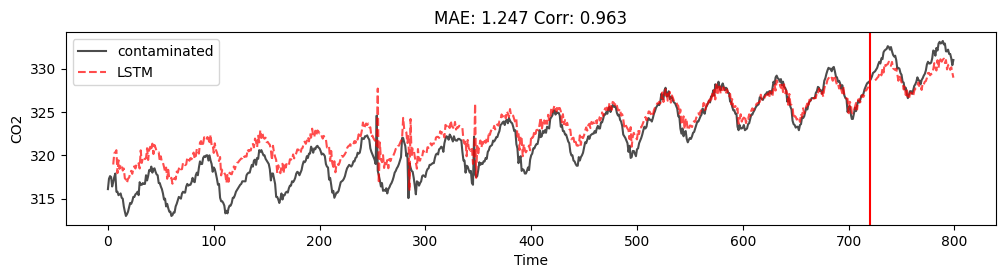

In [78]:
plt.figure(figsize=(12,2.5))
plt.plot(contam_series, c='k', label="contaminated", alpha=.7)
plt.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
plt.plot(contam_test_plot, c='r', linestyle="--", label="LSTM", alpha=.7)
plt.xlabel("Time")
plt.ylabel("CO2")
plt.title(f"MAE: {test_mae:.3f} Corr: {test_corr:.3f}")
plt.axvline(x=train_size, c="r")
plt.legend()
plt.show()

In [81]:
# -- influence functions
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

module = CGInfluenceModule(
    model=model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=100,
)

start = time.time()
all_train_idxs = list(range(X_train.shape[0]))
all_test_idxs = list(range(X_test.shape[0]))
influences = module.influences(train_idxs=all_train_idxs, test_idxs=all_test_idxs)
end = time.time()
print(f"time passed: {end - start} seconds.")

time passed: 189.14480996131897 seconds.


In [123]:
# -- LSTM-AE
torch.set_default_dtype(torch.float32)

detrended = detrend(contam_series.flatten()).reshape(-1,1)
train, test = detrended[:train_size], detrended[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback, device=DEVICE)
X_test, y_test = create_dataset(test, lookback=lookback, device=DEVICE)

train_dataset, seq_len, n_features = create_auto_encoder_dataset(y_train)
val_dataset, _, _ = create_auto_encoder_dataset(y_test)

model = RecurrentAutoencoder(seq_len, n_features, 50)
model = model.to(DEVICE)

start = time.time()
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=10
)

reconstructions, recon_losses = predict(model, train_dataset)
recon_losses = np.array(recon_losses)

end = time.time()
print(f"time passed: {end - start} seconds.")

Epoch 1: train loss 4.892599637525065 val loss 2.8191719468434653
Epoch 2: train loss 2.931071954632139 val loss 4.2372688881556195
Epoch 3: train loss 2.8243539524245094 val loss 2.515218814214071
Epoch 4: train loss 2.601572839988695 val loss 3.535680179595947
Epoch 5: train loss 2.636495009960828 val loss 3.4849289504686993
Epoch 6: train loss 2.4333116395490153 val loss 3.9317503515879313
Epoch 7: train loss 2.512541348492349 val loss 2.351099082628886
Epoch 8: train loss 2.4388195118704044 val loss 3.075149054527283
Epoch 9: train loss 2.3441554827706796 val loss 3.1369065006573993
Epoch 10: train loss 2.4116558170401965 val loss 2.4449327953656517
time passed: 47.540090799331665 seconds.


In [124]:
# Data OOB
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train, X_test = X_train.squeeze(), X_test.squeeze()
y_train, y_test = y_train.squeeze()[:,-1], y_test.squeeze()[:,-1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

problem='reg'
dargs = {'n_data_to_be_valued':len(X_train),
        'n_val':len(X_test),
        'n_test':len(X_train),
        'n_trees':500,
        'is_noisy': contam_perc,
        'model_family':'Tree',
        'run_id':0}

data_valuation_engine=DataValuation(
    X=X_train, y=y_train, X_val=X_test, y_val=y_test,
    problem=problem, dargs=dargs
)

start = time.time()
data_valuation_engine.compute_marginal_contribution_based_methods(betashap_run=False)
data_valuation_engine.compute_oob_and_ame()
end = time.time()
print(f"time passed: {end - start} seconds.")

oob_values = data_valuation_engine.data_value_dict["OOB"]
shapley_values = data_valuation_engine.data_value_dict["KNN_Shapley"]
loo_values = data_valuation_engine.data_value_dict["LOO_last"]

(715, 5) (715,)
(75, 5) (75,)
Start: KNN_Shapley computation
Done: KNN_Shapley computation
Start: LOO computation
Done: LOO computation
Start: OOB computation
Done: OOB computation
Start: AME computation
Done: AME computation
time passed: 63.10170793533325 seconds.


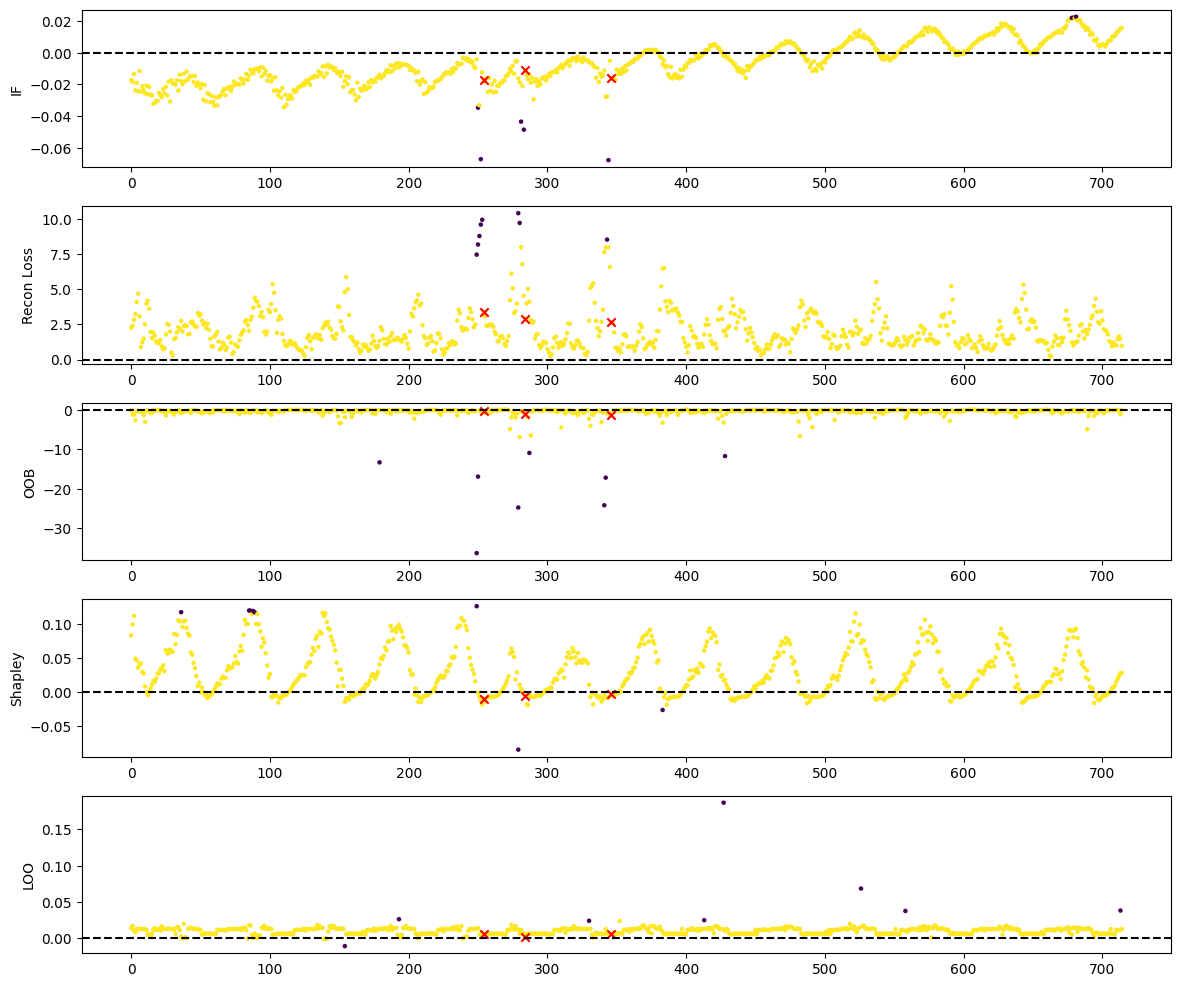

In [136]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

clf = IsolationForest(random_state=seed, contamination=contam_perc*2).fit(influences.reshape(-1,1))
IF_clusters = clf.predict(influences.reshape(-1,1))
ax1.scatter(np.arange(len(influences)), influences, c=IF_clusters, s=5)
ax1.scatter(anomaly_idx, influences[anomaly_idx], c="r", marker="x")
ax1.axhline(y=0, c="k", linestyle="--")
ax1.set_ylabel("IF")

clf = IsolationForest(random_state=seed, contamination=contam_perc*2).fit(recon_losses.reshape(-1,1))
lstm_ae_clusters = clf.predict(recon_losses.reshape(-1,1))
ax2.scatter(np.arange(len(recon_losses)), recon_losses, c=lstm_ae_clusters, s=5)
ax2.scatter(anomaly_idx, recon_losses[anomaly_idx], c="r", marker="x")
ax2.axhline(y=0, c="k", linestyle="--")
ax2.set_ylabel("Recon Loss")

clf = IsolationForest(random_state=seed, contamination=contam_perc*2).fit(oob_values.reshape(-1,1))
oob_clusters = clf.predict(oob_values.reshape(-1,1))
ax3.scatter(np.arange(len(oob_values)), oob_values, c=oob_clusters, s=5)
ax3.scatter(anomaly_idx, oob_values[anomaly_idx], c="r", marker="x")
ax3.axhline(y=0, c="k", linestyle="--")
ax3.set_ylabel("OOB")

clf = IsolationForest(random_state=seed, contamination=contam_perc*2).fit(shapley_values.reshape(-1,1))
shapley_clusters = clf.predict(shapley_values.reshape(-1,1))
ax4.scatter(np.arange(len(shapley_values)), shapley_values, c=shapley_clusters, s=5)
ax4.scatter(anomaly_idx, shapley_values[anomaly_idx], c="r", marker="x")
ax4.axhline(y=0, c="k", linestyle="--")
ax4.set_ylabel("Shapley")

clf = IsolationForest(random_state=seed, contamination=contam_perc*2).fit(loo_values.reshape(-1,1))
loo_clusters = clf.predict(loo_values.reshape(-1,1))
ax5.scatter(np.arange(len(loo_values)), loo_values, c=loo_clusters, s=5)
ax5.scatter(anomaly_idx, loo_values[anomaly_idx], c="r", marker="x")
ax5.axhline(y=0, c="k", linestyle="--")
ax5.set_ylabel("LOO")

plt.tight_layout()
plt.show()

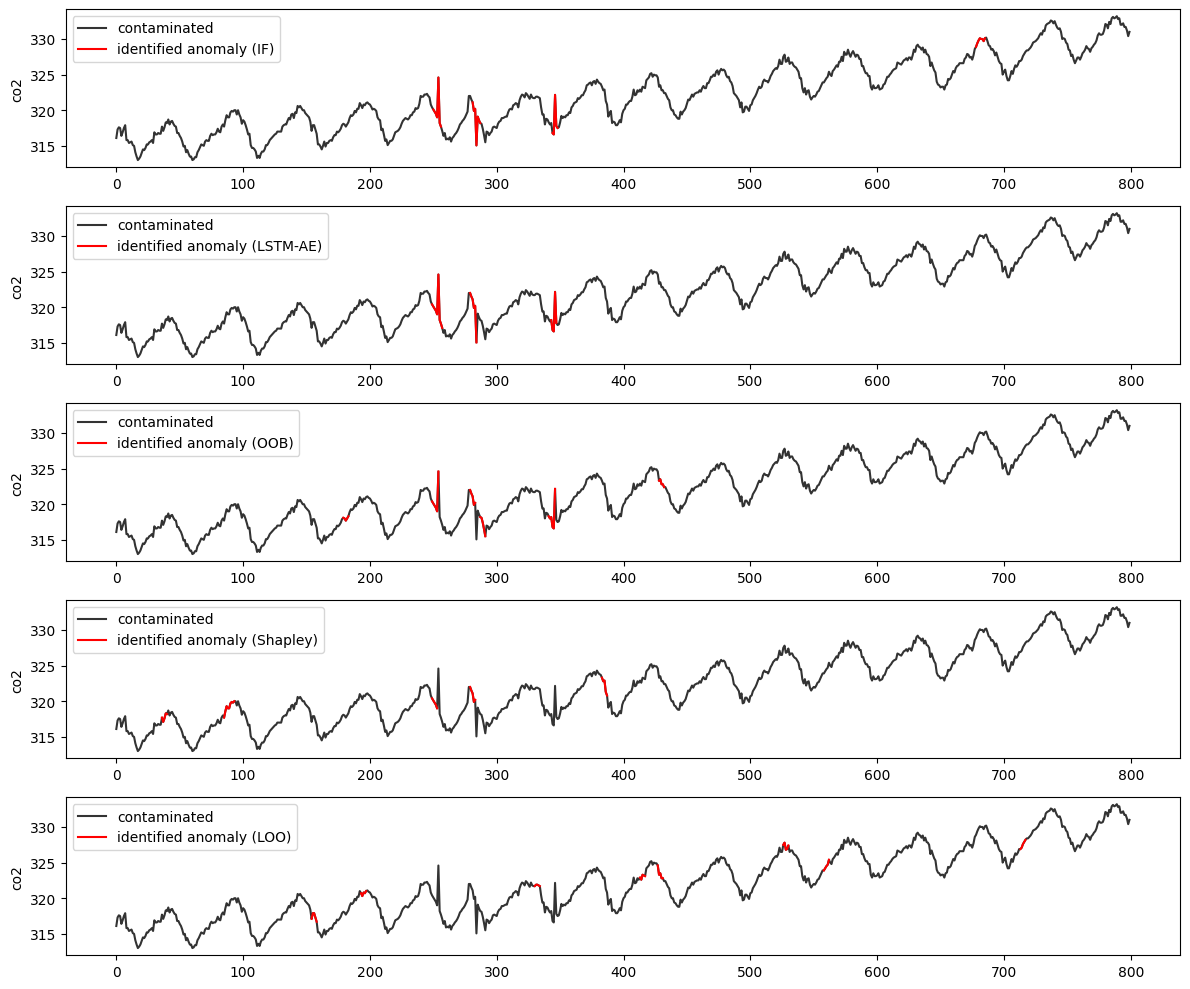

In [137]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

train, test = contam_series[:train_size], contam_series[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)

ax1.plot(contam_series, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(IF_clusters == -1)
anomaly_intervals = np.ones_like(contam_series.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax1.plot(anomaly_intervals, color='red', label='identified anomaly (IF)')

ax2.plot(contam_series, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(lstm_ae_clusters == -1)
anomaly_intervals = np.ones_like(contam_series.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax2.plot(anomaly_intervals, color='red', label='identified anomaly (LSTM-AE)')

ax3.plot(contam_series, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(oob_clusters == -1)
anomaly_intervals = np.ones_like(contam_series.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax3.plot(anomaly_intervals, color='red', label='identified anomaly (OOB)')

ax4.plot(contam_series, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(shapley_clusters == -1)
anomaly_intervals = np.ones_like(contam_series.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax4.plot(anomaly_intervals, color='red', label='identified anomaly (Shapley)')

ax5.plot(contam_series, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(loo_clusters == -1)
anomaly_intervals = np.ones_like(contam_series.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax5.plot(anomaly_intervals, color='red', label='identified anomaly (LOO)')


for ax in (ax1, ax2, ax3, ax4, ax5):
  ax.set_ylabel("co2")
  ax.legend()

plt.tight_layout()
plt.show()

UCR Anomaly Time Series

Dataset 1

In [138]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt"

insect_data = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
insect_data = insect_data[17000:17800]

duration = len(insect_data)
train_size = int(duration * 0.9)
test_size = duration - train_size
train, test = insect_data[:train_size], insect_data[train_size:]

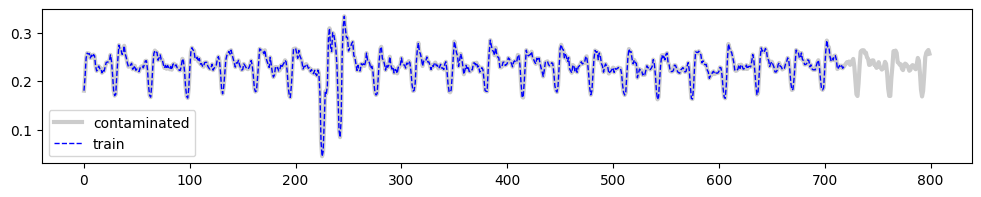

In [140]:
plt.figure(figsize=(12,2))
plt.plot(insect_data, color="k", linestyle="-", linewidth=3, alpha=.2, label="contaminated")
plt.plot(train, color="b", linestyle="--", linewidth=1, label="train")
plt.legend()
plt.show()

In [144]:
torch.set_default_dtype(torch.double)

lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback, device=DEVICE)
X_test, y_test = create_dataset(test, lookback=lookback, device=DEVICE)
y_train, y_test = y_train.squeeze(), y_test.squeeze()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([715, 5, 1]) torch.Size([715, 5])
torch.Size([75, 5, 1]) torch.Size([75, 5])


In [145]:
L2_WEIGHT = 1e-4
model = Forecaster().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=L2_WEIGHT)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [146]:
n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().numpy())
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().numpy())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0298, test RMSE 0.0255
Epoch 100: train RMSE 0.0173, test RMSE 0.0151
Epoch 200: train RMSE 0.0166, test RMSE 0.0144


In [147]:
with torch.no_grad():
    contam_train_plot = np.ones_like(insect_data).squeeze() * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    contam_train_plot[lookback:train_size] = model(X_train)[:, -1].cpu().numpy()
    contam_test_plot = np.ones_like(insect_data).squeeze() * np.nan
    contam_test_plot[train_size+lookback:duration] = model(X_test)[:, -1].cpu().numpy()

test_mae = mean_absolute_error(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)
test_corr = pearsonr(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)[0]

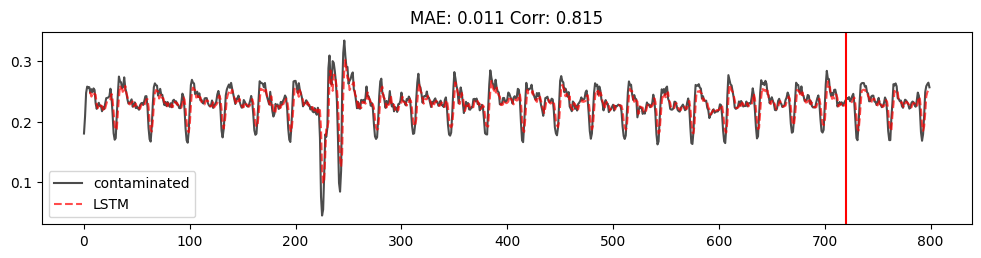

In [148]:
plt.figure(figsize=(12,2.5))
plt.plot(insect_data, c='k', label="contaminated", alpha=.7)
plt.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
plt.plot(contam_test_plot, c='r', linestyle="--", label="LSTM", alpha=.7)
plt.title(f"MAE: {test_mae:.3f} Corr: {test_corr:.3f}")
plt.axvline(x=train_size, c="r")
plt.legend()
plt.show()

In [149]:
# -- influence functions
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

module = CGInfluenceModule(
    model=model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=100,
)

start = time.time()
all_train_idxs = list(range(X_train.shape[0]))
all_test_idxs = list(range(X_test.shape[0]))
influences = module.influences(train_idxs=all_train_idxs, test_idxs=all_test_idxs)
end = time.time()
print(f"time passed: {end - start} seconds.")

time passed: 29.274423360824585 seconds.


In [151]:
# -- LSTM-AE
torch.set_default_dtype(torch.float32)

train_dataset, seq_len, n_features = create_auto_encoder_dataset(y_train.unsqueeze(-1))
val_dataset, _, _ = create_auto_encoder_dataset(y_test.unsqueeze(-1))

model = RecurrentAutoencoder(seq_len, n_features, 50)
model = model.to(DEVICE)

start = time.time()
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=10
)

reconstructions, recon_losses = predict(model, train_dataset)
recon_losses = np.array(recon_losses)

end = time.time()
print(f"time passed: {end - start} seconds.")

Epoch 1: train loss 0.1654850114788209 val loss 0.11213822980721791
Epoch 2: train loss 0.11691491005720792 val loss 0.1256681881348292
Epoch 3: train loss 0.11535438674313205 val loss 0.10863342106342316
Epoch 4: train loss 0.11296941185747827 val loss 0.10010965843995412
Epoch 5: train loss 0.11250052254099946 val loss 0.10870440363883972
Epoch 6: train loss 0.11204484551102965 val loss 0.08677231669425964
Epoch 7: train loss 0.11125915919567321 val loss 0.08601330518722534
Epoch 8: train loss 0.11020022157605712 val loss 0.0894499005873998
Epoch 9: train loss 0.10839774744077162 val loss 0.08658086498578389
Epoch 10: train loss 0.10639986208268812 val loss 0.08740927696228028
time passed: 106.90019989013672 seconds.


In [152]:
# Data OOB
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train, X_test = X_train.squeeze(), X_test.squeeze()
y_train, y_test = y_train.squeeze()[:,-1], y_test.squeeze()[:,-1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

problem='reg'
dargs = {'n_data_to_be_valued':len(X_train),
        'n_val':len(X_test),
        'n_test':len(X_train),
        'n_trees':500,
        'is_noisy': contam_perc,
        'model_family':'Tree',
        'run_id':0}

data_valuation_engine=DataValuation(
    X=X_train, y=y_train, X_val=X_test, y_val=y_test,
    problem=problem, dargs=dargs
)

start = time.time()
data_valuation_engine.compute_marginal_contribution_based_methods(betashap_run=False)
data_valuation_engine.compute_oob_and_ame()
end = time.time()
print(f"time passed: {end - start} seconds.")

oob_values = data_valuation_engine.data_value_dict["OOB"]
shapley_values = data_valuation_engine.data_value_dict["KNN_Shapley"]
loo_values = data_valuation_engine.data_value_dict["LOO_last"]

(715, 5) (715,)
(75, 5) (75,)
Start: KNN_Shapley computation
Done: KNN_Shapley computation
Start: LOO computation
Done: LOO computation
Start: OOB computation
Done: OOB computation
Start: AME computation
Done: AME computation
time passed: 78.77063488960266 seconds.


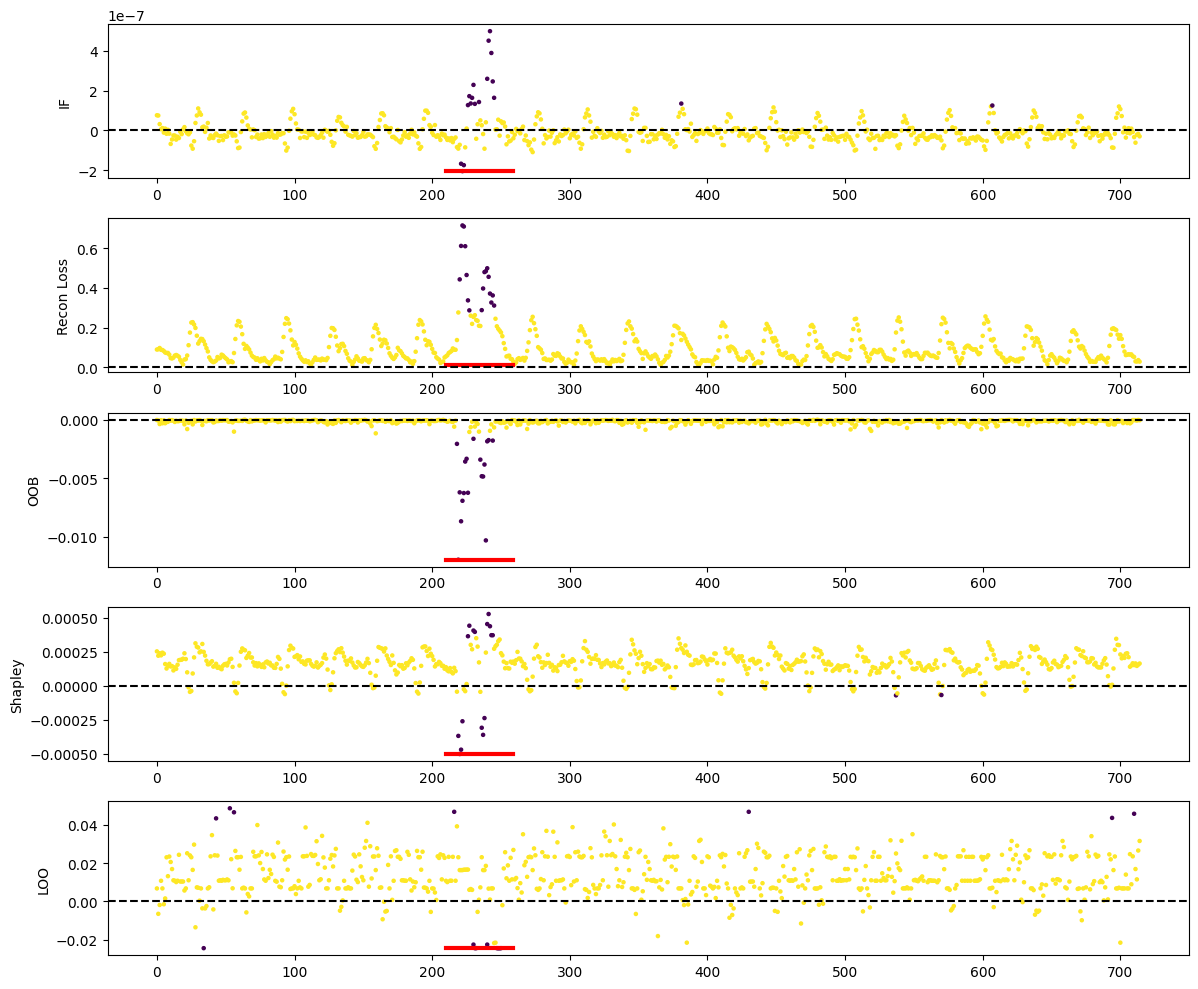

In [161]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

contam_perc = 0.025

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(influences.reshape(-1,1))
IF_clusters = clf.predict(influences.reshape(-1,1))
ax1.scatter(np.arange(len(influences)), influences, c=IF_clusters, s=5)
ax1.plot(np.arange(210, 260), np.ones_like(np.arange(210, 260)) * influences.numpy().min(), c="r", linewidth=3)
ax1.axhline(y=0, c="k", linestyle="--")
ax1.set_ylabel("IF")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(recon_losses.reshape(-1,1))
lstm_ae_clusters = clf.predict(recon_losses.reshape(-1,1))
ax2.scatter(np.arange(len(recon_losses)), recon_losses, c=lstm_ae_clusters, s=5)
ax2.plot(np.arange(210, 260), np.ones_like(np.arange(210, 260)) * recon_losses.min(), c="r", linewidth=3)
ax2.axhline(y=0, c="k", linestyle="--")
ax2.set_ylabel("Recon Loss")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(oob_values.reshape(-1,1))
oob_clusters = clf.predict(oob_values.reshape(-1,1))
ax3.scatter(np.arange(len(oob_values)), oob_values, c=oob_clusters, s=5)
ax3.plot(np.arange(210, 260), np.ones_like(np.arange(210, 260)) * oob_values.min(), c="r", linewidth=3)
ax3.axhline(y=0, c="k", linestyle="--")
ax3.set_ylabel("OOB")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(shapley_values.reshape(-1,1))
shapley_clusters = clf.predict(shapley_values.reshape(-1,1))
ax4.scatter(np.arange(len(shapley_values)), shapley_values, c=shapley_clusters, s=5)
ax4.plot(np.arange(210, 260), np.ones_like(np.arange(210, 260)) * shapley_values.min(), c="r", linewidth=3)
ax4.axhline(y=0, c="k", linestyle="--")
ax4.set_ylabel("Shapley")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(loo_values.reshape(-1,1))
loo_clusters = clf.predict(loo_values.reshape(-1,1))
ax5.scatter(np.arange(len(loo_values)), loo_values, c=loo_clusters, s=5)
ax5.plot(np.arange(210, 260), np.ones_like(np.arange(210, 260)) * loo_values.min(), c="r", linewidth=3)
ax5.axhline(y=0, c="k", linestyle="--")
ax5.set_ylabel("LOO")

plt.tight_layout()
plt.show()

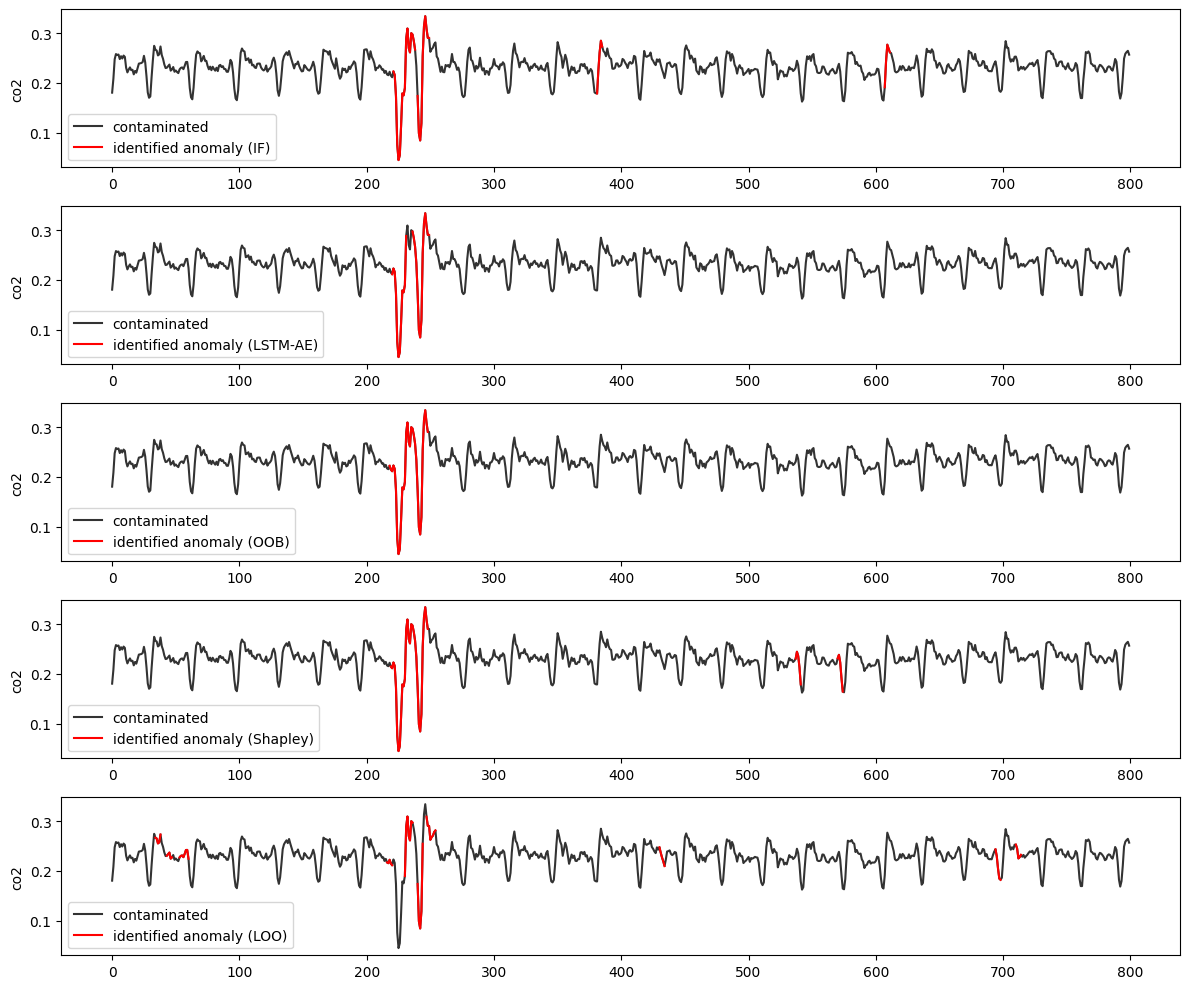

In [162]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

train, test = insect_data[:train_size], insect_data[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)

ax1.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(IF_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax1.plot(anomaly_intervals, color='red', label='identified anomaly (IF)')

ax2.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(lstm_ae_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax2.plot(anomaly_intervals, color='red', label='identified anomaly (LSTM-AE)')

ax3.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(oob_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax3.plot(anomaly_intervals, color='red', label='identified anomaly (OOB)')

ax4.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(shapley_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax4.plot(anomaly_intervals, color='red', label='identified anomaly (Shapley)')

ax5.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(loo_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax5.plot(anomaly_intervals, color='red', label='identified anomaly (LOO)')


for ax in (ax1, ax2, ax3, ax4, ax5):
  ax.set_ylabel("co2")
  ax.legend()

plt.tight_layout()
plt.show()

Dataset 2

In [163]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt"

insect_data = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
insect_data = insect_data[12000:13000]

duration = len(insect_data)
train_size = int(duration * 0.9)
test_size = duration - train_size
train, test = insect_data[:train_size], insect_data[train_size:]

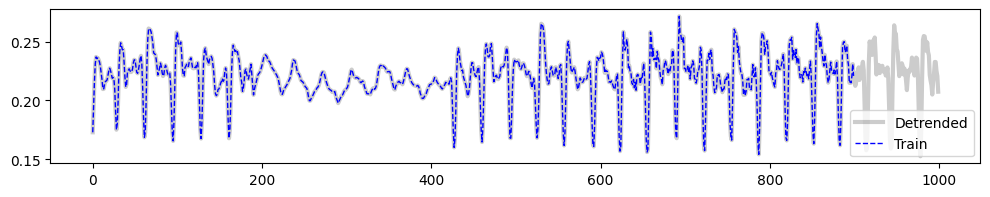

In [164]:
plt.figure(figsize=(12,2))
plt.plot(insect_data, color="k", linestyle="-", linewidth=3, alpha=.2, label="Detrended")
plt.plot(train, color="b", linestyle="--", linewidth=1, label="Train")
plt.legend()
plt.show()

In [165]:
torch.set_default_dtype(torch.double)

lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback, device=DEVICE)
X_test, y_test = create_dataset(test, lookback=lookback, device=DEVICE)
y_train, y_test = y_train.squeeze(), y_test.squeeze()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([895, 5, 1]) torch.Size([895, 5])
torch.Size([95, 5, 1]) torch.Size([95, 5])


In [166]:
L2_WEIGHT = 1e-4
model = Forecaster().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=L2_WEIGHT)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [167]:
n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().numpy())
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().numpy())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1295, test RMSE 0.1312
Epoch 100: train RMSE 0.0117, test RMSE 0.0153
Epoch 200: train RMSE 0.0126, test RMSE 0.0161


In [168]:
with torch.no_grad():
    contam_train_plot = np.ones_like(insect_data).squeeze() * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    contam_train_plot[lookback:train_size] = model(X_train)[:, -1].cpu().numpy()
    contam_test_plot = np.ones_like(insect_data).squeeze() * np.nan
    contam_test_plot[train_size+lookback:duration] = model(X_test)[:, -1].cpu().numpy()

test_mae = mean_absolute_error(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)
test_corr = pearsonr(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)[0]

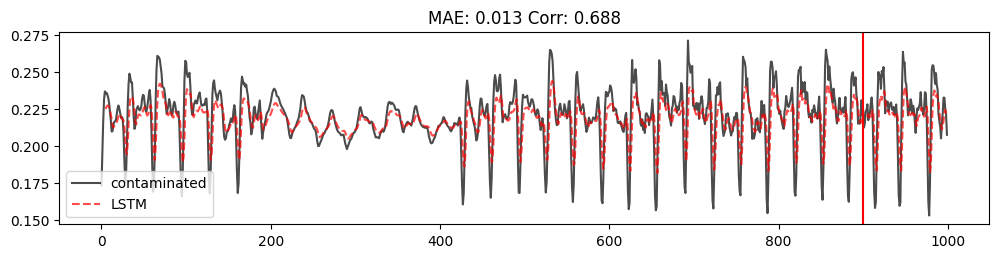

In [169]:
plt.figure(figsize=(12,2.5))
plt.plot(insect_data, c='k', label="contaminated", alpha=.7)
plt.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
plt.plot(contam_test_plot, c='r', linestyle="--", label="LSTM", alpha=.7)
plt.title(f"MAE: {test_mae:.3f} Corr: {test_corr:.3f}")
plt.axvline(x=train_size, c="r")
plt.legend()
plt.show()

In [170]:
# -- influence functions
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

module = CGInfluenceModule(
    model=model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=100,
)

start = time.time()
all_train_idxs = list(range(X_train.shape[0]))
all_test_idxs = list(range(X_test.shape[0]))
influences = module.influences(train_idxs=all_train_idxs, test_idxs=all_test_idxs)
end = time.time()
print(f"time passed: {end - start} seconds.")

time passed: 21.78864622116089 seconds.


In [171]:
# -- LSTM-AE
torch.set_default_dtype(torch.float32)

train_dataset, seq_len, n_features = create_auto_encoder_dataset(y_train.unsqueeze(-1))
val_dataset, _, _ = create_auto_encoder_dataset(y_test.unsqueeze(-1))

model = RecurrentAutoencoder(seq_len, n_features, 50)
model = model.to(DEVICE)

start = time.time()
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=10
)

reconstructions, recon_losses = predict(model, train_dataset)
recon_losses = np.array(recon_losses)

end = time.time()
print(f"time passed: {end - start} seconds.")

Epoch 1: train loss 0.10138373028632648 val loss 0.0916770360971752
Epoch 2: train loss 0.07362374693321783 val loss 0.08019990811222479
Epoch 3: train loss 0.07376526783964488 val loss 0.08239634460524509
Epoch 4: train loss 0.07523662064994514 val loss 0.08081882831297423
Epoch 5: train loss 0.07280157208442688 val loss 0.07947719301048078
Epoch 6: train loss 0.0702964236116942 val loss 0.08021800047472903
Epoch 7: train loss 0.06824255665587313 val loss 0.07967338562011719
Epoch 8: train loss 0.06767870256021702 val loss 0.07960098825002972
Epoch 9: train loss 0.06827447647488984 val loss 0.08120121500994029
Epoch 10: train loss 0.06756338801796875 val loss 0.0835606408746619
time passed: 134.83152508735657 seconds.


In [172]:
# Data OOB
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train, X_test = X_train.squeeze(), X_test.squeeze()
y_train, y_test = y_train.squeeze()[:,-1], y_test.squeeze()[:,-1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

problem='reg'
dargs = {'n_data_to_be_valued':len(X_train),
        'n_val':len(X_test),
        'n_test':len(X_train),
        'n_trees':500,
        'is_noisy': contam_perc,
        'model_family':'Tree',
        'run_id':0}

data_valuation_engine=DataValuation(
    X=X_train, y=y_train, X_val=X_test, y_val=y_test,
    problem=problem, dargs=dargs
)

start = time.time()
data_valuation_engine.compute_marginal_contribution_based_methods(betashap_run=False)
data_valuation_engine.compute_oob_and_ame()
end = time.time()
print(f"time passed: {end - start} seconds.")

oob_values = data_valuation_engine.data_value_dict["OOB"]
shapley_values = data_valuation_engine.data_value_dict["KNN_Shapley"]
loo_values = data_valuation_engine.data_value_dict["LOO_last"]

(895, 5) (895,)
(95, 5) (95,)
Start: KNN_Shapley computation
Done: KNN_Shapley computation
Start: LOO computation
Done: LOO computation
Start: OOB computation
Done: OOB computation
Start: AME computation
Done: AME computation
time passed: 85.32008075714111 seconds.


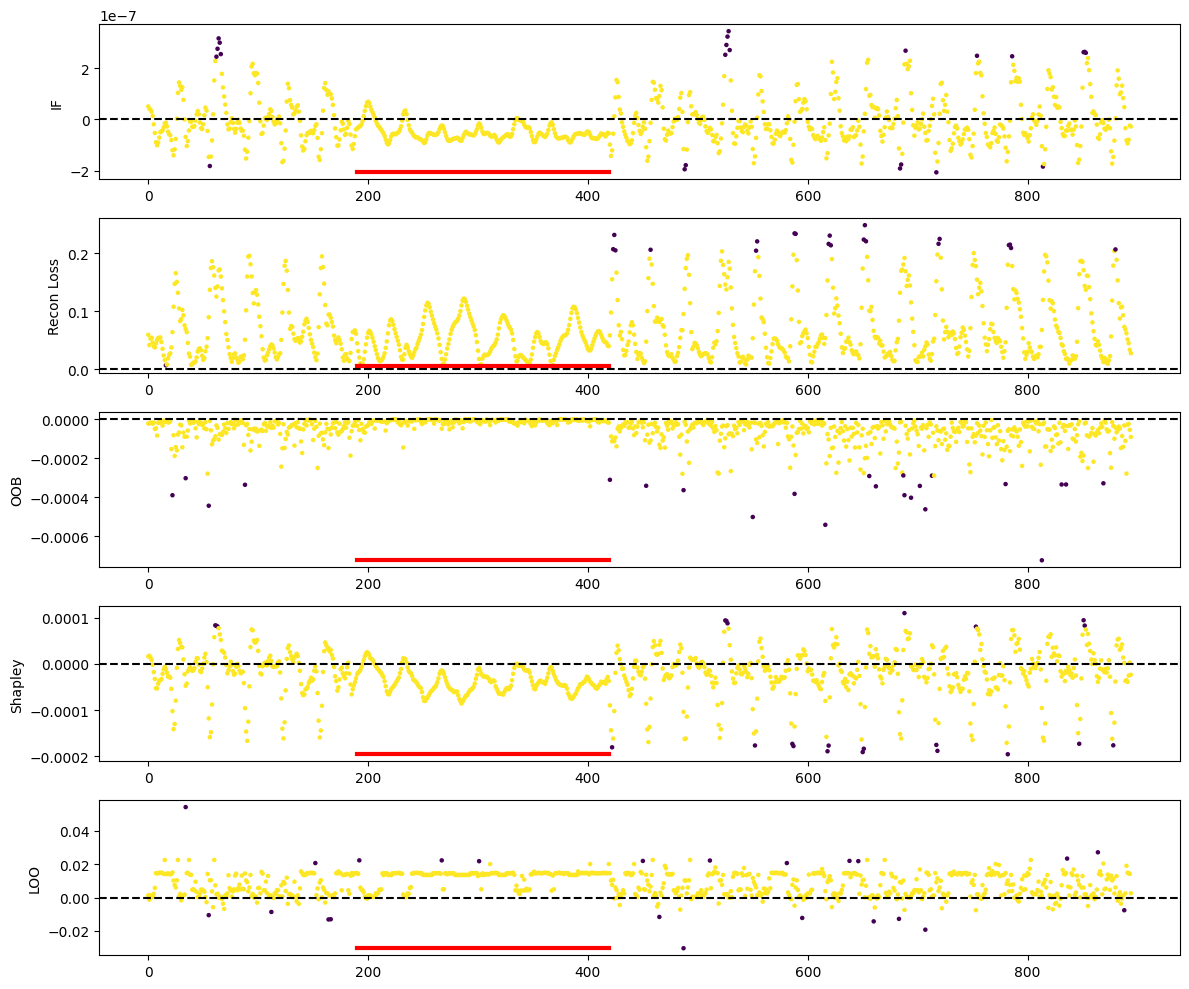

In [173]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

contam_perc = 0.025

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(influences.reshape(-1,1))
IF_clusters = clf.predict(influences.reshape(-1,1))
ax1.scatter(np.arange(len(influences)), influences, c=IF_clusters, s=5)
ax1.plot(np.arange(190, 420), np.ones_like(np.arange(190, 420)) * influences.numpy().min(), c="r", linewidth=3)
ax1.axhline(y=0, c="k", linestyle="--")
ax1.set_ylabel("IF")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(recon_losses.reshape(-1,1))
lstm_ae_clusters = clf.predict(recon_losses.reshape(-1,1))
ax2.scatter(np.arange(len(recon_losses)), recon_losses, c=lstm_ae_clusters, s=5)
ax2.plot(np.arange(190, 420), np.ones_like(np.arange(190, 420)) * recon_losses.min(), c="r", linewidth=3)
ax2.axhline(y=0, c="k", linestyle="--")
ax2.set_ylabel("Recon Loss")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(oob_values.reshape(-1,1))
oob_clusters = clf.predict(oob_values.reshape(-1,1))
ax3.scatter(np.arange(len(oob_values)), oob_values, c=oob_clusters, s=5)
ax3.plot(np.arange(190, 420), np.ones_like(np.arange(190, 420)) * oob_values.min(), c="r", linewidth=3)
ax3.axhline(y=0, c="k", linestyle="--")
ax3.set_ylabel("OOB")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(shapley_values.reshape(-1,1))
shapley_clusters = clf.predict(shapley_values.reshape(-1,1))
ax4.scatter(np.arange(len(shapley_values)), shapley_values, c=shapley_clusters, s=5)
ax4.plot(np.arange(190, 420), np.ones_like(np.arange(190, 420)) * shapley_values.min(), c="r", linewidth=3)
ax4.axhline(y=0, c="k", linestyle="--")
ax4.set_ylabel("Shapley")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(loo_values.reshape(-1,1))
loo_clusters = clf.predict(loo_values.reshape(-1,1))
ax5.scatter(np.arange(len(loo_values)), loo_values, c=loo_clusters, s=5)
ax5.plot(np.arange(190, 420), np.ones_like(np.arange(190, 420)) * loo_values.min(), c="r", linewidth=3)
ax5.axhline(y=0, c="k", linestyle="--")
ax5.set_ylabel("LOO")

plt.tight_layout()
plt.show()

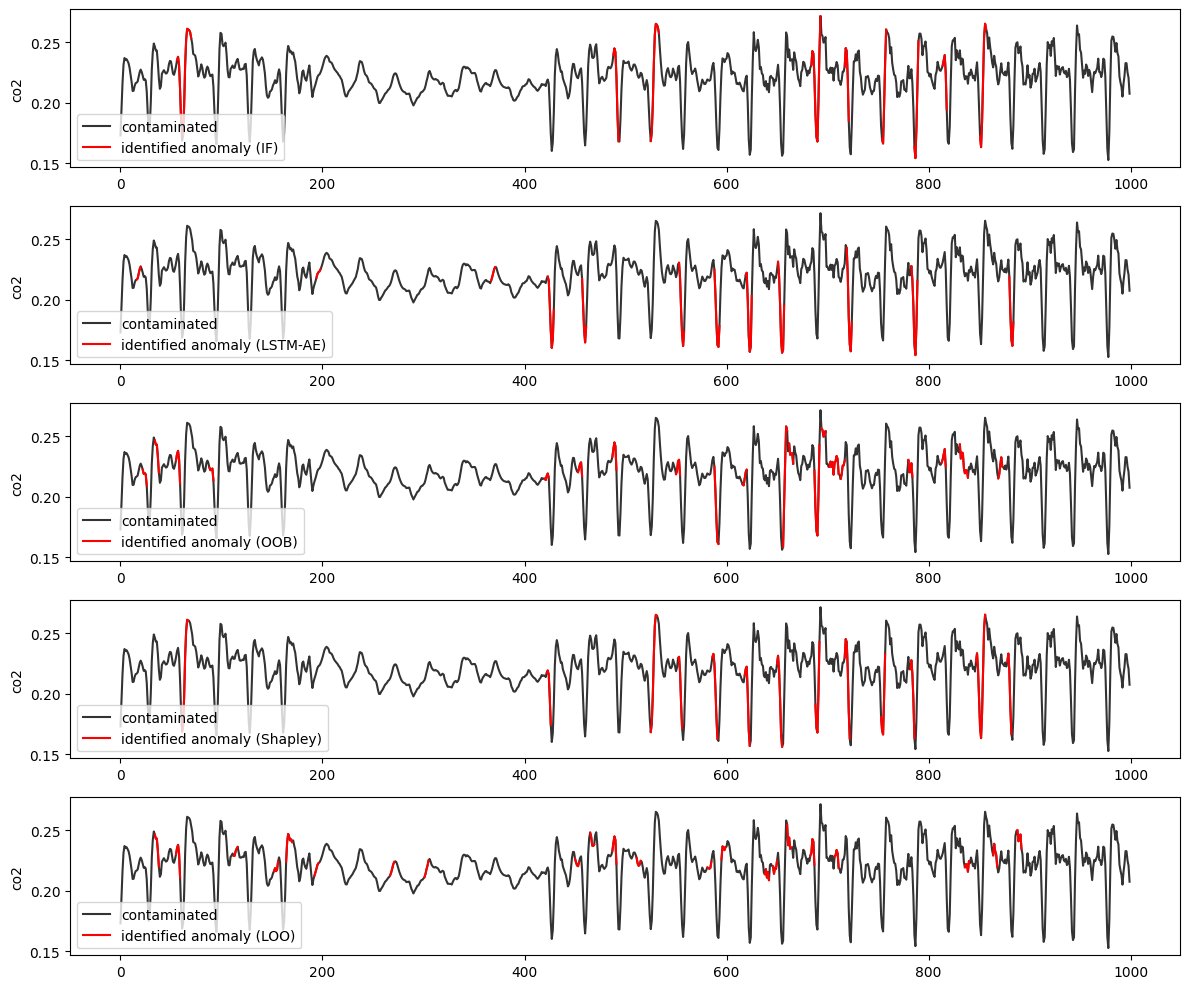

In [174]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

train, test = insect_data[:train_size], insect_data[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)

ax1.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(IF_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax1.plot(anomaly_intervals, color='red', label='identified anomaly (IF)')

ax2.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(lstm_ae_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax2.plot(anomaly_intervals, color='red', label='identified anomaly (LSTM-AE)')

ax3.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(oob_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax3.plot(anomaly_intervals, color='red', label='identified anomaly (OOB)')

ax4.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(shapley_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax4.plot(anomaly_intervals, color='red', label='identified anomaly (Shapley)')

ax5.plot(insect_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(loo_clusters == -1)
anomaly_intervals = np.ones_like(insect_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax5.plot(anomaly_intervals, color='red', label='identified anomaly (LOO)')


for ax in (ax1, ax2, ax3, ax4, ax5):
  ax.set_ylabel("co2")
  ax.legend()

plt.tight_layout()
plt.show()

Dataset 3

In [175]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt"

gait_data = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
gait_data = gait_data[32800:33800]

duration = len(gait_data)
print(duration)
train_size = int(duration * 0.9)
test_size = duration - train_size
train, test = gait_data[:train_size], gait_data[train_size:]

1000


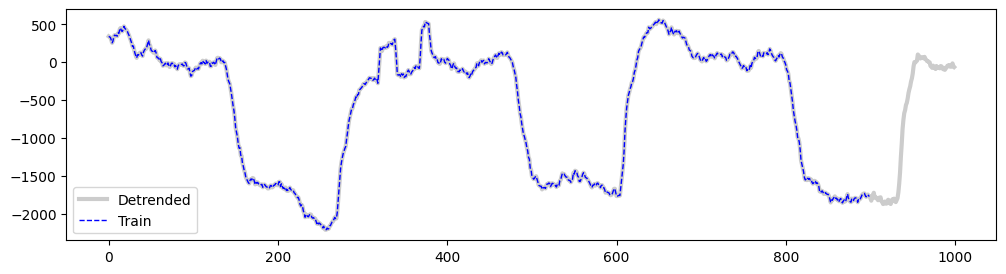

In [176]:
plt.figure(figsize=(12,3))
plt.plot(gait_data, color="k", linestyle="-", linewidth=3, alpha=.2, label="Detrended")
plt.plot(train, color="b", linestyle="--", linewidth=1, label="Train")
plt.legend()
plt.show()

In [177]:
torch.set_default_dtype(torch.double)

lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback, device=DEVICE)
X_test, y_test = create_dataset(test, lookback=lookback, device=DEVICE)
y_train, y_test = y_train.squeeze(), y_test.squeeze()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([895, 5, 1]) torch.Size([895, 5])
torch.Size([95, 5, 1]) torch.Size([95, 5])


In [187]:
class Forecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 1)
        self.flatten = nn.Flatten(start_dim=-2)
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x)
        x = self.flatten(x)
        return x

L2_WEIGHT = 1e-4
model = Forecaster().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=L2_WEIGHT)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [188]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().numpy())
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().numpy())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 1038.6365, test RMSE 1086.8042
Epoch 100: train RMSE 635.4636, test RMSE 685.9798
Epoch 200: train RMSE 290.3282, test RMSE 331.5180
Epoch 300: train RMSE 107.0044, test RMSE 103.2148
Epoch 400: train RMSE 91.7558, test RMSE 75.0503
Epoch 500: train RMSE 120.7893, test RMSE 121.1152
Epoch 600: train RMSE 97.0202, test RMSE 85.3813
Epoch 700: train RMSE 103.8850, test RMSE 96.0574
Epoch 800: train RMSE 107.0006, test RMSE 102.8787
Epoch 900: train RMSE 80.2698, test RMSE 89.0310


In [189]:
with torch.no_grad():
    contam_train_plot = np.ones_like(gait_data).squeeze() * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    contam_train_plot[lookback:train_size] = model(X_train)[:, -1].cpu().numpy()
    contam_test_plot = np.ones_like(gait_data).squeeze() * np.nan
    contam_test_plot[train_size+lookback:duration] = model(X_test)[:, -1].cpu().numpy()

test_mae = mean_absolute_error(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)
test_corr = pearsonr(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)[0]

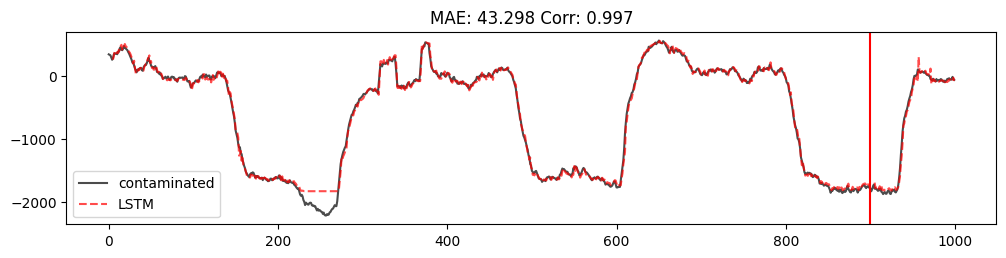

In [190]:
plt.figure(figsize=(12,2.5))
plt.plot(gait_data, c='k', label="contaminated", alpha=.7)
plt.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
plt.plot(contam_test_plot, c='r', linestyle="--", label="LSTM", alpha=.7)
plt.title(f"MAE: {test_mae:.3f} Corr: {test_corr:.3f}")
plt.axvline(x=train_size, c="r")
plt.legend()
plt.show()

In [191]:
# -- influence functions
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

module = CGInfluenceModule(
    model=model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=400,
)

start = time.time()
all_train_idxs = list(range(X_train.shape[0]))
all_test_idxs = list(range(X_test.shape[0]))
influences = module.influences(train_idxs=all_train_idxs, test_idxs=all_test_idxs)
end = time.time()
print(f"time passed: {end - start} seconds.")

time passed: 443.27898597717285 seconds.


In [193]:
# -- LSTM-AE
torch.set_default_dtype(torch.float32)

train_dataset, seq_len, n_features = create_auto_encoder_dataset(y_train.unsqueeze(-1))
val_dataset, _, _ = create_auto_encoder_dataset(y_test.unsqueeze(-1))

model = RecurrentAutoencoder(seq_len, n_features, 50)
model = model.to(DEVICE)

start = time.time()
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=50
)

reconstructions, recon_losses = predict(model, train_dataset)
recon_losses = np.array(recon_losses)

end = time.time()
print(f"time passed: {end - start} seconds.")

Epoch 1: train loss 3522.467152583799 val loss 3445.706213700144
Epoch 2: train loss 3367.496219528454 val loss 3425.6051295230263
Epoch 3: train loss 3244.285138250596 val loss 3373.2121575606498
Epoch 4: train loss 3104.141135826324 val loss 3147.1358840139287
Epoch 5: train loss 2962.6131472411766 val loss 2994.7760598835193
Epoch 6: train loss 2820.99970768124 val loss 2897.15271373548
Epoch 7: train loss 2704.2834091016034 val loss 2782.1036843149286
Epoch 8: train loss 2612.4709201812743 val loss 2748.1190419648824
Epoch 9: train loss 2510.1740967862434 val loss 2615.665771644994
Epoch 10: train loss 2422.7734240185614 val loss 2548.2522197121066
Epoch 11: train loss 2328.224344492225 val loss 2439.093007097746
Epoch 12: train loss 2218.6797658547343 val loss 2315.3187275133637
Epoch 13: train loss 2108.064625208338 val loss 2256.597995155736
Epoch 14: train loss 2079.7327211689017 val loss 2252.3736346596165
Epoch 15: train loss 1975.6311291092602 val loss 2188.301752753007
Epoc

In [194]:
# Data OOB
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train, X_test = X_train.squeeze(), X_test.squeeze()
y_train, y_test = y_train.squeeze()[:,-1], y_test.squeeze()[:,-1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

problem='reg'
dargs = {'n_data_to_be_valued':len(X_train),
        'n_val':len(X_test),
        'n_test':len(X_train),
        'n_trees':500,
        'is_noisy': contam_perc,
        'model_family':'Tree',
        'run_id':0}

data_valuation_engine=DataValuation(
    X=X_train, y=y_train, X_val=X_test, y_val=y_test,
    problem=problem, dargs=dargs
)

start = time.time()
data_valuation_engine.compute_marginal_contribution_based_methods(betashap_run=False)
data_valuation_engine.compute_oob_and_ame()
end = time.time()
print(f"time passed: {end - start} seconds.")

oob_values = data_valuation_engine.data_value_dict["OOB"]
shapley_values = data_valuation_engine.data_value_dict["KNN_Shapley"]
loo_values = data_valuation_engine.data_value_dict["LOO_last"]

(895, 5) (895,)
(95, 5) (95,)
Start: KNN_Shapley computation
Done: KNN_Shapley computation
Start: LOO computation
Done: LOO computation
Start: OOB computation
Done: OOB computation
Start: AME computation
Done: AME computation
time passed: 91.11863875389099 seconds.


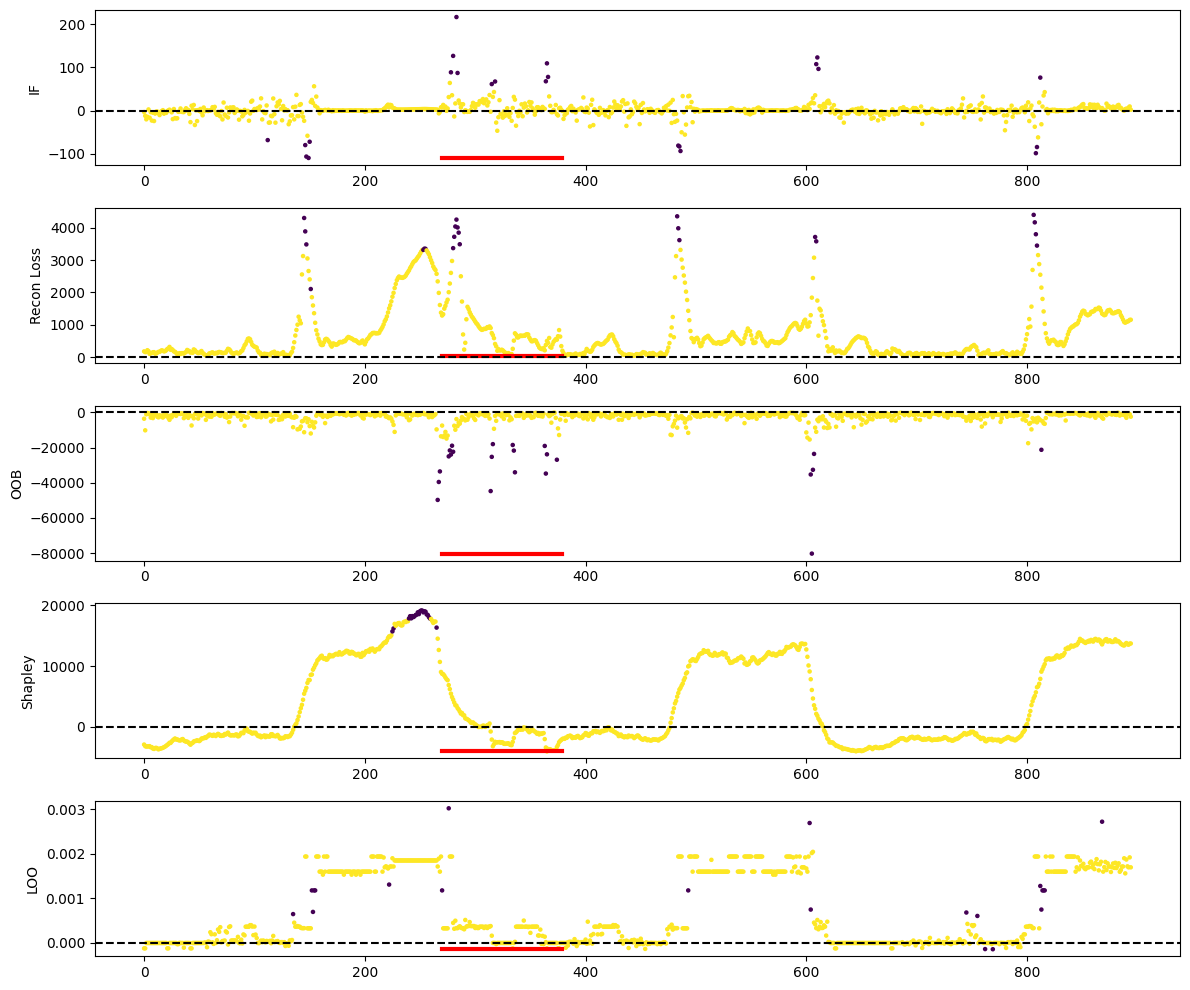

In [195]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

contam_perc = 0.025

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(influences.reshape(-1,1))
IF_clusters = clf.predict(influences.reshape(-1,1))
ax1.scatter(np.arange(len(influences)), influences, c=IF_clusters, s=5)
ax1.plot(np.arange(270, 380), np.ones_like(np.arange(270, 380)) * influences.numpy().min(), c="r", linewidth=3)
ax1.axhline(y=0, c="k", linestyle="--")
ax1.set_ylabel("IF")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(recon_losses.reshape(-1,1))
lstm_ae_clusters = clf.predict(recon_losses.reshape(-1,1))
ax2.scatter(np.arange(len(recon_losses)), recon_losses, c=lstm_ae_clusters, s=5)
ax2.plot(np.arange(270, 380), np.ones_like(np.arange(270, 380)) * recon_losses.min(), c="r", linewidth=3)
ax2.axhline(y=0, c="k", linestyle="--")
ax2.set_ylabel("Recon Loss")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(oob_values.reshape(-1,1))
oob_clusters = clf.predict(oob_values.reshape(-1,1))
ax3.scatter(np.arange(len(oob_values)), oob_values, c=oob_clusters, s=5)
ax3.plot(np.arange(270, 380), np.ones_like(np.arange(270, 380)) * oob_values.min(), c="r", linewidth=3)
ax3.axhline(y=0, c="k", linestyle="--")
ax3.set_ylabel("OOB")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(shapley_values.reshape(-1,1))
shapley_clusters = clf.predict(shapley_values.reshape(-1,1))
ax4.scatter(np.arange(len(shapley_values)), shapley_values, c=shapley_clusters, s=5)
ax4.plot(np.arange(270, 380), np.ones_like(np.arange(270, 380)) * shapley_values.min(), c="r", linewidth=3)
ax4.axhline(y=0, c="k", linestyle="--")
ax4.set_ylabel("Shapley")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(loo_values.reshape(-1,1))
loo_clusters = clf.predict(loo_values.reshape(-1,1))
ax5.scatter(np.arange(len(loo_values)), loo_values, c=loo_clusters, s=5)
ax5.plot(np.arange(270, 380), np.ones_like(np.arange(270, 380)) * loo_values.min(), c="r", linewidth=3)
ax5.axhline(y=0, c="k", linestyle="--")
ax5.set_ylabel("LOO")

plt.tight_layout()
plt.show()

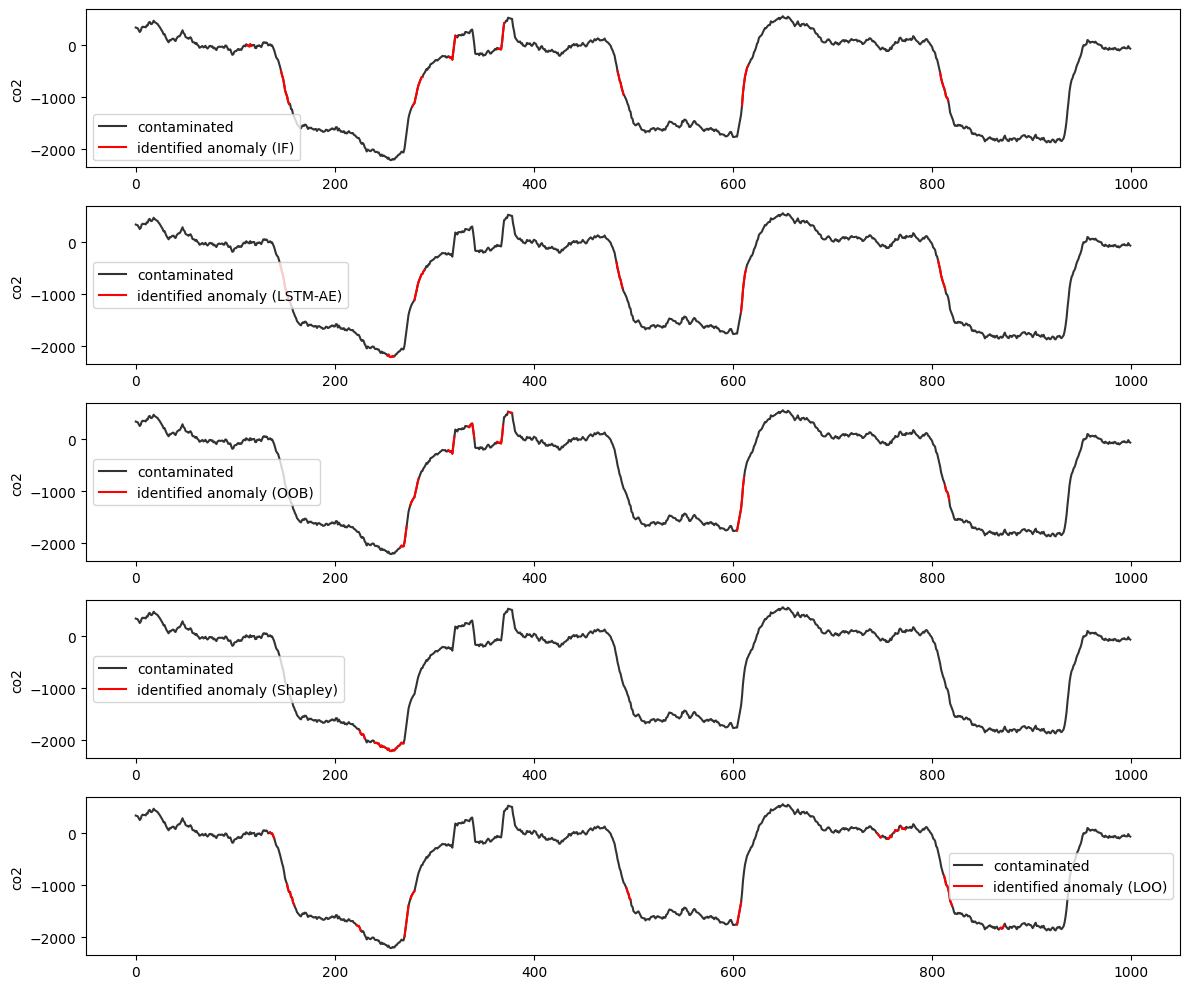

In [196]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

train, test = gait_data[:train_size], gait_data[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)

ax1.plot(gait_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(IF_clusters == -1)
anomaly_intervals = np.ones_like(gait_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax1.plot(anomaly_intervals, color='red', label='identified anomaly (IF)')

ax2.plot(gait_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(lstm_ae_clusters == -1)
anomaly_intervals = np.ones_like(gait_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax2.plot(anomaly_intervals, color='red', label='identified anomaly (LSTM-AE)')

ax3.plot(gait_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(oob_clusters == -1)
anomaly_intervals = np.ones_like(gait_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax3.plot(anomaly_intervals, color='red', label='identified anomaly (OOB)')

ax4.plot(gait_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(shapley_clusters == -1)
anomaly_intervals = np.ones_like(gait_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax4.plot(anomaly_intervals, color='red', label='identified anomaly (Shapley)')

ax5.plot(gait_data, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(loo_clusters == -1)
anomaly_intervals = np.ones_like(gait_data.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax5.plot(anomaly_intervals, color='red', label='identified anomaly (LOO)')


for ax in (ax1, ax2, ax3, ax4, ax5):
  ax.set_ylabel("co2")
  ax.legend()

plt.tight_layout()
plt.show()

Dataset 4

In [197]:
data_dir = "/content/drive/MyDrive/time_series_influences/ucr_time_series_anomaly_datasets/data/"
file_name = "003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt"

ECG = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ECG = ECG[46500:47500]

duration = len(ECG)
print(duration)
train_size = int(duration * 0.9)
test_size = duration - train_size
train, test = ECG[:train_size], ECG[train_size:]

1000


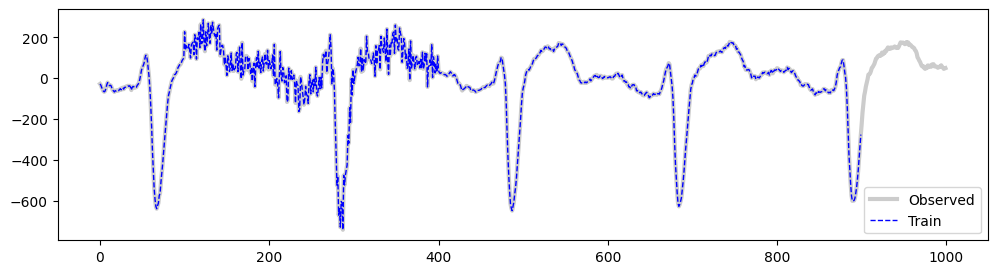

In [198]:
plt.figure(figsize=(12,3))
plt.plot(ECG, color="k", linestyle="-", linewidth=3, alpha=.2, label="Observed")
plt.plot(train, color="b", linestyle="--", linewidth=1, label="Train")
plt.legend()
plt.show()

In [199]:
torch.set_default_dtype(torch.double)

lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback, device=DEVICE)
X_test, y_test = create_dataset(test, lookback=lookback, device=DEVICE)
y_train, y_test = y_train.squeeze(), y_test.squeeze()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([895, 5, 1]) torch.Size([895, 5])
torch.Size([95, 5, 1]) torch.Size([95, 5])


In [200]:
L2_WEIGHT = 1e-4
model = Forecaster().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=L2_WEIGHT)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [201]:
n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().numpy())
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().numpy())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 170.9085, test RMSE 107.0576
Epoch 100: train RMSE 56.7548, test RMSE 13.0092
Epoch 200: train RMSE 39.2893, test RMSE 12.8392


In [202]:
with torch.no_grad():
    contam_train_plot = np.ones_like(ECG).squeeze() * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    contam_train_plot[lookback:train_size] = model(X_train)[:, -1].cpu().numpy()
    contam_test_plot = np.ones_like(ECG).squeeze() * np.nan
    contam_test_plot[train_size+lookback:duration] = model(X_test)[:, -1].cpu().numpy()

test_mae = mean_absolute_error(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)
test_corr = pearsonr(
    model(X_test)[:,-1].cpu().detach().numpy().flatten(),
    y_test[:,-1].cpu().flatten()
)[0]

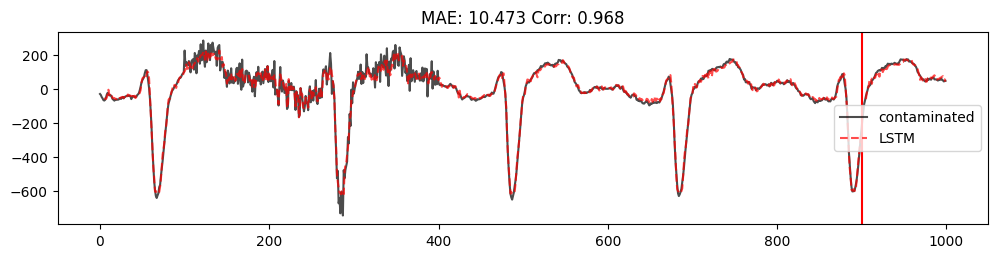

In [203]:
plt.figure(figsize=(12,2.5))
plt.plot(ECG, c='k', label="contaminated", alpha=.7)
plt.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
plt.plot(contam_test_plot, c='r', linestyle="--", label="LSTM", alpha=.7)
plt.title(f"MAE: {test_mae:.3f} Corr: {test_corr:.3f}")
plt.axvline(x=train_size, c="r")
plt.legend()
plt.show()

In [204]:
# -- influence functions
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

module = CGInfluenceModule(
    model=model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=300,
)

start = time.time()
all_train_idxs = list(range(X_train.shape[0]))
all_test_idxs = list(range(X_test.shape[0]))
influences = module.influences(train_idxs=all_train_idxs, test_idxs=all_test_idxs)
end = time.time()
print(f"time passed: {end - start} seconds.")

time passed: 345.1402518749237 seconds.


In [205]:
# -- LSTM-AE
torch.set_default_dtype(torch.float32)

train_dataset, seq_len, n_features = create_auto_encoder_dataset(y_train.unsqueeze(-1))
val_dataset, _, _ = create_auto_encoder_dataset(y_test.unsqueeze(-1))

model = RecurrentAutoencoder(seq_len, n_features, 50)
model = model.to(DEVICE)

start = time.time()
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=30
)

reconstructions, recon_losses = predict(model, train_dataset)
recon_losses = np.array(recon_losses)

end = time.time()
print(f"time passed: {end - start} seconds.")

Epoch 1: train loss 460.45165222636814 val loss 295.9100167525442
Epoch 2: train loss 442.5500182279661 val loss 241.78435130872225
Epoch 3: train loss 420.85032313442764 val loss 236.10579645257246
Epoch 4: train loss 406.51682227790025 val loss 155.3767044870477
Epoch 5: train loss 408.96780624496205 val loss 267.30229122764183
Epoch 6: train loss 419.28101056274755 val loss 521.7253731175473
Epoch 7: train loss 386.28068045078044 val loss 79.41289974011873
Epoch 8: train loss 313.57417666152867 val loss 89.88489134939093
Epoch 9: train loss 269.2324166100784 val loss 95.05602284481651
Epoch 10: train loss 284.2117778064152 val loss 58.278069265265216
Epoch 11: train loss 245.56639839257608 val loss 95.0285096821032
Epoch 12: train loss 237.53769630773107 val loss 68.04678071674547
Epoch 13: train loss 225.1964809257891 val loss 75.44354360480058
Epoch 14: train loss 222.63717804647692 val loss 123.47912641826429
Epoch 15: train loss 217.25533949942562 val loss 66.19631335609837
Epoc

In [206]:
# Data OOB
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train, X_test = X_train.squeeze(), X_test.squeeze()
y_train, y_test = y_train.squeeze()[:,-1], y_test.squeeze()[:,-1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

problem='reg'
dargs = {'n_data_to_be_valued':len(X_train),
        'n_val':len(X_test),
        'n_test':len(X_train),
        'n_trees':500,
        'is_noisy': contam_perc,
        'model_family':'Tree',
        'run_id':0}

data_valuation_engine=DataValuation(
    X=X_train, y=y_train, X_val=X_test, y_val=y_test,
    problem=problem, dargs=dargs
)

start = time.time()
data_valuation_engine.compute_marginal_contribution_based_methods(betashap_run=False)
data_valuation_engine.compute_oob_and_ame()
end = time.time()
print(f"time passed: {end - start} seconds.")

oob_values = data_valuation_engine.data_value_dict["OOB"]
shapley_values = data_valuation_engine.data_value_dict["KNN_Shapley"]
loo_values = data_valuation_engine.data_value_dict["LOO_last"]

(895, 5) (895,)
(95, 5) (95,)
Start: KNN_Shapley computation
Done: KNN_Shapley computation
Start: LOO computation
Done: LOO computation
Start: OOB computation
Done: OOB computation
Start: AME computation
Done: AME computation
time passed: 88.5589530467987 seconds.


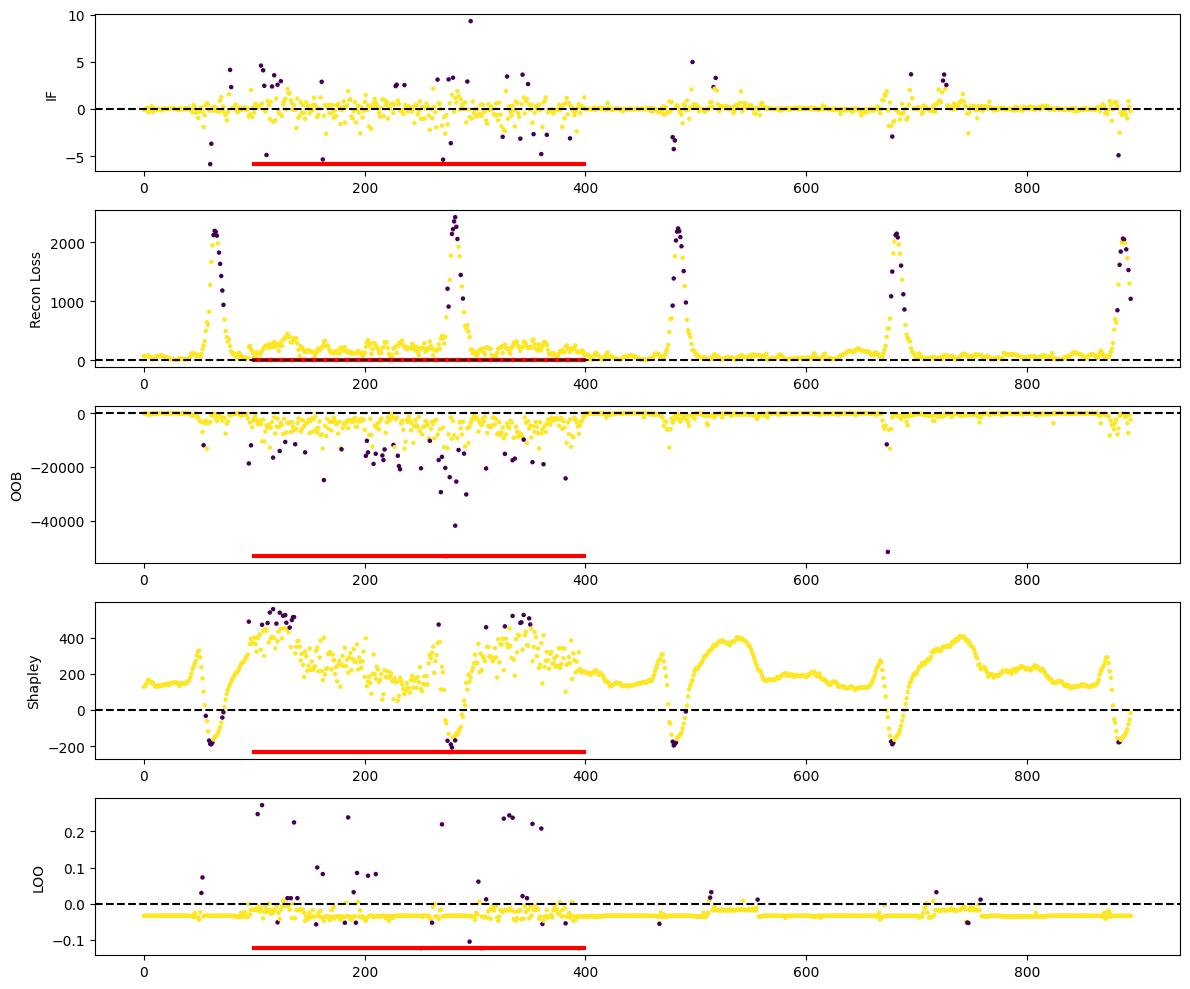

In [209]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

contam_perc = 0.05

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(influences.reshape(-1,1))
IF_clusters = clf.predict(influences.reshape(-1,1))
ax1.scatter(np.arange(len(influences)), influences, c=IF_clusters, s=5)
ax1.plot(np.arange(100, 400), np.ones_like(np.arange(100, 400)) * influences.numpy().min(), c="r", linewidth=3)
ax1.axhline(y=0, c="k", linestyle="--")
ax1.set_ylabel("IF")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(recon_losses.reshape(-1,1))
lstm_ae_clusters = clf.predict(recon_losses.reshape(-1,1))
ax2.scatter(np.arange(len(recon_losses)), recon_losses, c=lstm_ae_clusters, s=5)
ax2.plot(np.arange(100, 400), np.ones_like(np.arange(100, 400)) * recon_losses.min(), c="r", linewidth=3)
ax2.axhline(y=0, c="k", linestyle="--")
ax2.set_ylabel("Recon Loss")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(oob_values.reshape(-1,1))
oob_clusters = clf.predict(oob_values.reshape(-1,1))
ax3.scatter(np.arange(len(oob_values)), oob_values, c=oob_clusters, s=5)
ax3.plot(np.arange(100, 400), np.ones_like(np.arange(100, 400)) * oob_values.min(), c="r", linewidth=3)
ax3.axhline(y=0, c="k", linestyle="--")
ax3.set_ylabel("OOB")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(shapley_values.reshape(-1,1))
shapley_clusters = clf.predict(shapley_values.reshape(-1,1))
ax4.scatter(np.arange(len(shapley_values)), shapley_values, c=shapley_clusters, s=5)
ax4.plot(np.arange(100, 400), np.ones_like(np.arange(100, 400)) * shapley_values.min(), c="r", linewidth=3)
ax4.axhline(y=0, c="k", linestyle="--")
ax4.set_ylabel("Shapley")

clf = IsolationForest(random_state=seed, contamination=contam_perc).fit(loo_values.reshape(-1,1))
loo_clusters = clf.predict(loo_values.reshape(-1,1))
ax5.scatter(np.arange(len(loo_values)), loo_values, c=loo_clusters, s=5)
ax5.plot(np.arange(100, 400), np.ones_like(np.arange(100, 400)) * loo_values.min(), c="r", linewidth=3)
ax5.axhline(y=0, c="k", linestyle="--")
ax5.set_ylabel("LOO")

plt.tight_layout()
plt.show()

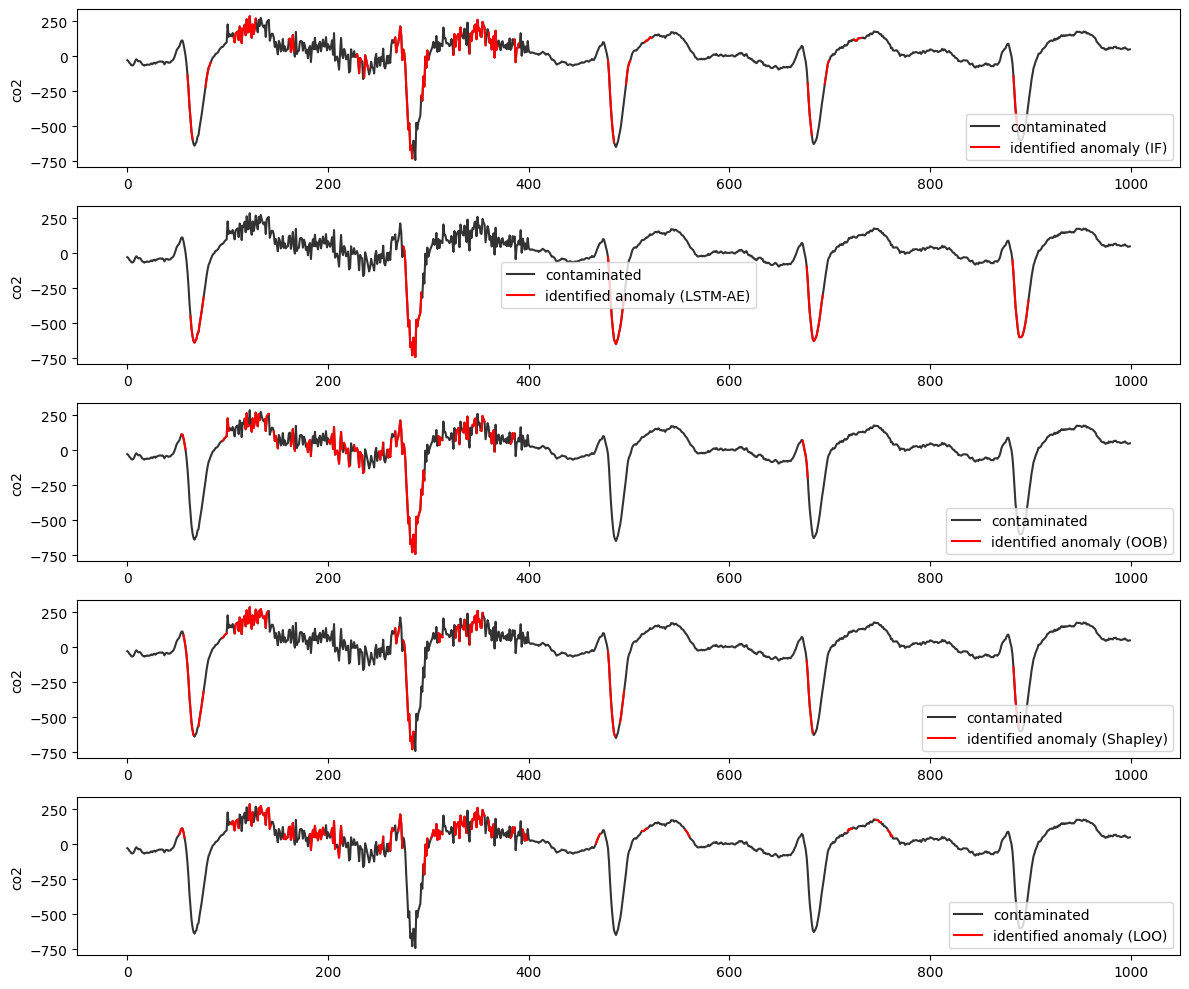

In [210]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 10))

train, test = ECG[:train_size], ECG[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)

ax1.plot(ECG, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(IF_clusters == -1)
anomaly_intervals = np.ones_like(ECG.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax1.plot(anomaly_intervals, color='red', label='identified anomaly (IF)')

ax2.plot(ECG, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(lstm_ae_clusters == -1)
anomaly_intervals = np.ones_like(ECG.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax2.plot(anomaly_intervals, color='red', label='identified anomaly (LSTM-AE)')

ax3.plot(ECG, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(oob_clusters == -1)
anomaly_intervals = np.ones_like(ECG.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax3.plot(anomaly_intervals, color='red', label='identified anomaly (OOB)')

ax4.plot(ECG, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(shapley_clusters == -1)
anomaly_intervals = np.ones_like(ECG.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax4.plot(anomaly_intervals, color='red', label='identified anomaly (Shapley)')

ax5.plot(ECG, c='k', linestyle="-", label="contaminated", alpha=.8)
anomaly_idxs = np.argwhere(loo_clusters == -1)
anomaly_intervals = np.ones_like(ECG.flatten()) * np.nan
for _, point_idx in enumerate(anomaly_idxs):
    interval_idxs = np.ones(lookback)*point_idx + np.arange(lookback)
    anomaly_intervals[interval_idxs.astype(int)] = X_train[point_idx].flatten()
ax5.plot(anomaly_intervals, color='red', label='identified anomaly (LOO)')


for ax in (ax1, ax2, ax3, ax4, ax5):
  ax.set_ylabel("co2")
  ax.legend()

plt.tight_layout()
plt.show()